**CALL CENTER OPERATIONS ANALYTICS** <br>

Author Diana Kung'u

Questions:
1. Number/proportion of Calls per Reason <br>
     - summary numbers
2. Call Center activity peak analysis <br> 
     - Distribution of Calls by day of week/month and hour of day
     
3. Queue Analysis <br> 
     - Abandonment rate <br>

     - Estimate number of potential customers lost.

     - Wait Duration <br>
4. Schedule Optimization <br> 
     - Utilization rate/idle time <br>
     - Incoming calls

5. Agent Performance


In [3]:
# Load libraries
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='white')

In [4]:

#Read data
#.............................................................................................
chunks = pd.read_csv(r'.\Data\call center.csv', parse_dates=['Call Date Time'], chunksize= 5000)
call_df = pd.concat(chunks, ignore_index= True)

In [5]:
df = call_df.copy()
df.head(3)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s)
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6


**Data Preparation**


In [6]:
#Split call date and time fields
Call_Date, Call_Time= zip(*[(d.date(), d.time()) for d in df['Call Date Time']])
df['Call Date'], df['Call Time'] =[Call_Date, Call_Time]

#Format Date and time columns to datetime objects
df['Call Date'] = pd.to_datetime(df['Call Date'], format='%Y-%m-%d')
df['Call Time'] = df['Call Time'].apply(lambda x: x.strftime('%H:%M'))
df.head(2)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21


In [7]:
# Parse the Year, Month Day, and hour of each call
df['Year'] = df['Call Date'].dt.year
df['Month'] = df['Call Date'].dt.month
df['Day of Week'] = [d.strftime("%A") for d in df['Call Date']]
df['Hour'] =  df['Call Date Time'].dt.hour
df['Day'] = df['Call Date'].dt.day
df.head(3)


,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time,Year,Month,Day of Week,Hour,Day
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46,2021,11,Tuesday,9,30
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21,2021,11,Monday,8,29
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6,2021-11-18,10:20,2021,11,Thursday,10,18


In [8]:
#Duplicated Call #
df.drop_duplicates(keep='first', inplace= True)
#df[df.duplicated(['Call #'])]
df.drop_duplicates('Call #', keep='first', inplace= True)

In [9]:
# Bin Wait time
wait_bin = [0, 30, 90, 180, 300, 10000]
wait_bin_labels = ['<30s', '30-90s', '91-180s', '181-300s', '>300s']
df['Wait Time Bins'] = pd.cut(df['Wait Time (s)'], bins= wait_bin, labels= wait_bin_labels)

In [10]:
talk_bin = [0, 60, 180, 300, 480, 10000]
talk_bin_labels = ['<1 min', '1 -3 mins', '3- 5 mins', '5 - 8 mins', '>8 mins']
df['Talk Time Bins'] = pd.cut(df['Talk Time (s)'], bins= talk_bin, labels= talk_bin_labels)
df['Talk Time Bins'].value_counts()

1 -3 mins     81598
3- 5 mins     67296
5 - 8 mins    40947
<1 min        27642
>8 mins       22990
Name: Talk Time Bins, dtype: int64

1. **Summary Analysis**<br>

What is the number/proportion of incoming calls per reason. <br>
Total number of agents / Total number of customers <br>
Number of incoming calls. <br>

i. Frequency of Calls by reason

In [11]:
# Unique call reasons
reasons  = df['Call Reason'].unique().tolist()
#Frequency of each reason
df_reasons = df.groupby(['Call Reason']).agg(No_Calls =('Call #', 'count')).reset_index()
df_reasons['Proportion'] =df_reasons['No_Calls']*100/df_reasons['No_Calls'].sum()
df_reasons['Proportion %'] = df_reasons['Proportion'].map('{:,.1f}%'.format)
df_reasons

,Call Reason,No_Calls,Proportion,Proportion %
0,Billing Questions,53107,22.061548,22.1%
1,Internet Outage,69534,28.885602,28.9%
2,New Customer,5580,2.318027,2.3%
3,Other,889,0.369306,0.4%
4,Product/Service Problems,20950,8.702985,8.7%
5,Technical Issues,90662,37.662532,37.7%


Text(0, 0.5, '')

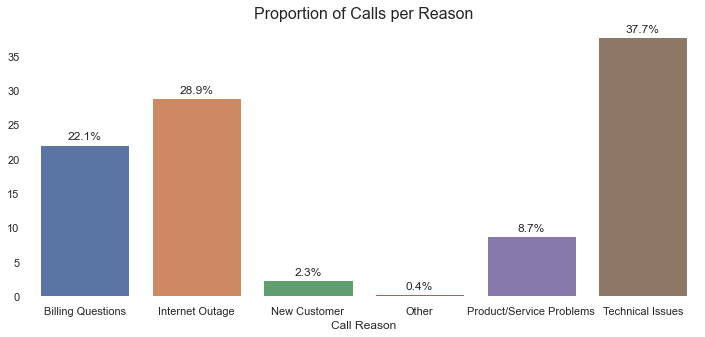

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
plt.title('Proportion of Calls per Reason', fontsize = 16)

sns.despine(bottom = True, left = True)
plot = sns.barplot(x = 'Call Reason', y = 'Proportion', data = df_reasons)

#Annotate bar plots
for bar, annot in zip(plot.patches, df_reasons['Proportion %']): 
    plot.annotate(annot,
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
ax.set_ylabel('') 

Technical Issues, Internet Outages and Billing Questions account for the largest number
of calls.

ii. Total number of agents and customers

In [13]:
#Total Incoming call in 2021
total_incoming_calls = len(df[df['Year'] ==2021])
#No. of Agents
no_agents = df[df['Year'] ==2021]['Agent'].nunique()
no_customers = df['Customer'].nunique()

2. **Call Center activity: Peak Analysis** <br>

   I. Day of month/week

Number of calls per reason by day/day of week are evenly distributed.

In [14]:
df_day_distribution = df.groupby(['Call Reason', 'Day of Week']).agg(No_Calls =('Call #', 'count')).reset_index()
df_day_distribution.head(2)

,Call Reason,Day of Week,No_Calls
0,Billing Questions,Friday,8815
1,Billing Questions,Monday,10712


In [15]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_day_distribution['Day of Week'] = (pd.Categorical(df_day_distribution['Day of Week'], 
                                                     categories=ordered_days, ordered=True))
df_day_distribution['Day of Week'].sort_index(inplace= True)

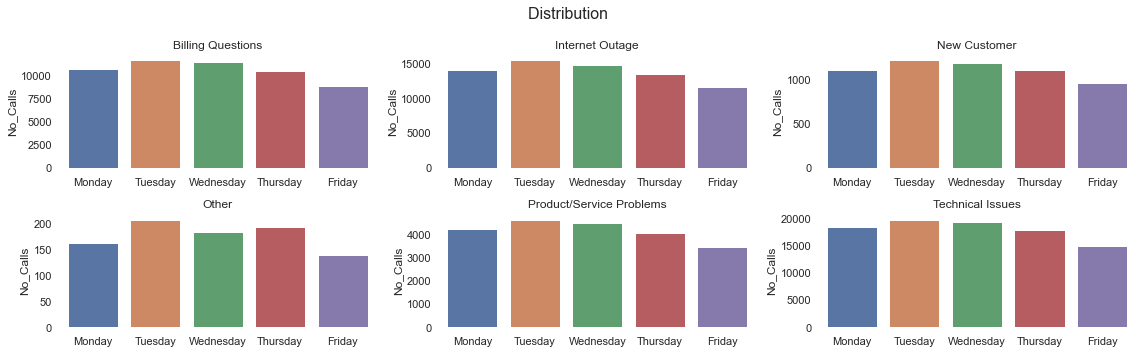

In [16]:
figure, ax = plt.subplots(2,3, figsize=(16, 5), facecolor='w', edgecolor='k', sharex= True)

a = 2 #rows
b = 3 # columns
c = 1 # subplot iterator

for i in df_day_distribution['Call Reason'].unique():
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel(i)
    plt.suptitle('Distribution ', size=16)
    plt.ylabel('')
    plt.xlabel('')

    #cmap = sns.diverging_palette(220, 20, as_cmap=True)
    k = sns.barplot(x = 'Day of Week', y = 'No_Calls', 
                    data = df_day_distribution[df_day_distribution['Call Reason'] == i])
    sns.despine(bottom = True, left = True)
    
    c = c + 1
    k.set_xlabel('')
fig.subplots_adjust(hspace=1)
plt.tight_layout()
                 


In [21]:
#Distribution by hour and day of week
#Heatmap 
daily_dist = df[df['Year'] ==2021].groupby(['Day of Week','Hour']).agg(
                                No_Calls =('Call #', 'count'),
                                No_days = ('Call Date', 'nunique'),
                                No_staff = ('Agent', 'nunique')).reset_index()
daily_dist['Average Calls per Day_hour'] = (daily_dist['No_Calls']/ daily_dist['No_days']).astype(int)
daily_dist.head(2)

,Day of Week,Hour,No_Calls,No_days,No_staff,Average Calls per Day_hour
0,Friday,8,570,48,23,11
1,Friday,9,2126,48,28,44


In [26]:
daily_dist_avg_call_per_hr = daily_dist.pivot_table(index= 'Day of Week', columns= 'Hour', 
                                   values = 'Average Calls per Day_hour', aggfunc='first', fill_value=0)
daily_dist_avg_call_per_hr.index = (pd.Categorical(daily_dist_avg_call_per_hr.index, 
                                                   categories=ordered_days, ordered=True))
daily_dist_avg_call_per_hr.sort_index(inplace= True)
daily_dist_avg_call_per_hr

Hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Monday,1,13,47,65,72,65,68,71,69,54,11,10,4,1
Tuesday,0,17,54,68,76,64,67,71,69,53,10,4,4,0
Wednesday,1,17,51,72,77,63,64,65,65,51,9,11,7,0
Thursday,0,14,48,68,72,60,59,65,60,51,9,5,4,0
Friday,0,11,44,57,64,53,56,55,53,38,6,9,2,0


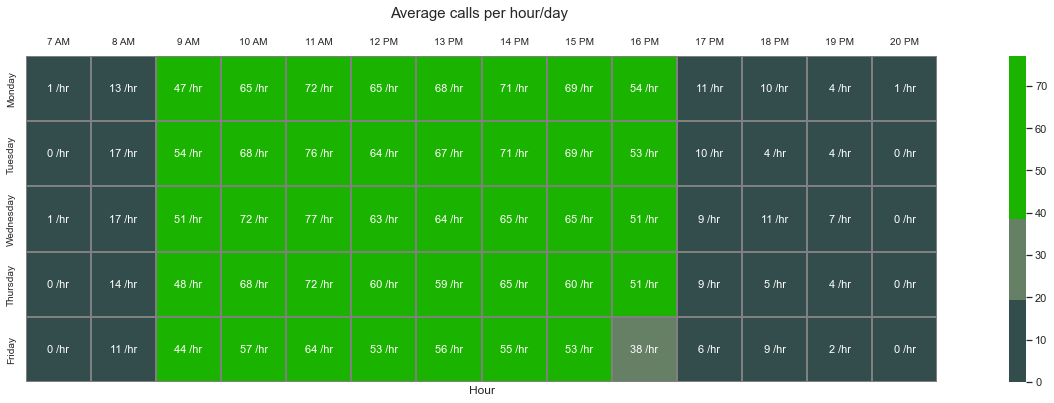

In [28]:

fig,ax = plt.subplots(1,1,figsize=(20,5))
my_colors=[(0.2,0.3,0.3),(0.4,0.5,0.4),(0.1,0.7,0),(0.1,0.7,0)]
xticks = [str(x)+' AM' if x < 12 else str(x)+' PM' for x in daily_dist_avg_call_per_hr.columns]

h_map = sns.heatmap(data =daily_dist_avg_call_per_hr, cmap=my_colors, xticklabels=xticks,
                    square =True, linecolor= 'gray', 
                    linewidth =0.1, annot= True, annot_kws={"size": 11}, ax=ax)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.tight_layout(pad=0.08)

for t in h_map.texts: t.set_text(t.get_text() + " /hr")
plt.ylabel('')
plt.title('Average calls per hour/day ', size =15, y = 1.1)

plt.show()



**Queue Analysis** <br>

    - Wait Time
    What is the average wait time for all, completed and abandoned calls?

In [38]:
avg_wait_all = round(df[df['Year'] ==2021]['Wait Time (s)'].mean())
avg_wait_completed = round(df[(df['Year'] ==2021) & (df['Abandon Flag'] == 'Y')]['Wait Time (s)'].mean())
avg_wait_incomplete = round(df[(df['Year'] ==2021) & (df['Abandon Flag'] == 'N')]['Wait Time (s)'].mean())

print(f'The average wait times for all, completed and incomplete calls are {avg_wait_all}s, {avg_wait_completed}s and {avg_wait_incomplete}s respectively.')

The average wait times for all, completed and incomplete calls are 52s, 75s and 52s respectively.


    - What is the average wait time per reason of call for abandoned calls?

In [65]:
df_wait_reason = (df[df['Year'] == 2021].groupby(['Call Reason', 'Abandon Flag'],
                                        as_index = False)['Wait Time (s)'].mean().round(1).pivot_table(
                                        index= 'Call Reason', columns ='Abandon Flag', fill_value =0).
                                        reset_index())#.rename_axis(None, axis=1))
df_wait_reason.columns = ['Call Reason', 'Avg_wait - completed', 'Avg_wait - incomplete']
df_wait_reason

,Call Reason,Avg_wait - completed,Avg_wait - incomplete
0,Billing Questions,52.5,90.0
1,Internet Outage,51.7,61.5
2,New Customer,52.9,79.8
3,Other,50.1,0.0
4,Product/Service Problems,53.2,102.3
5,Technical Issues,52.9,72.6


    - Distribution Wait time

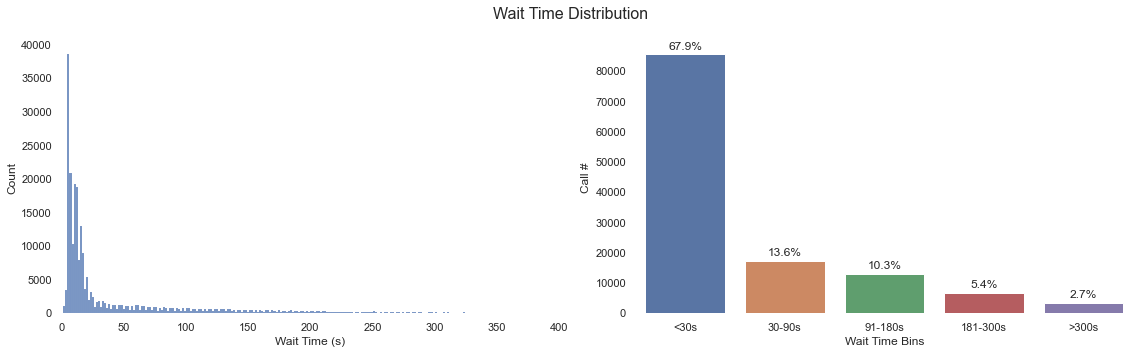

In [97]:
fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize=(16,5))
plt.suptitle('Wait Time Distribution', fontsize = 16)

sns.despine(bottom = True, left = True)
sns.histplot(df['Wait Time (s)'], ax =ax[0])
ax[0].set_xlim(0,400)

data = df[df['Year'] == 2021].groupby(['Wait Time Bins'])['Call #'].count().reset_index()
data['%_Calls'] = (data['Call #'] * 100 /data['Call #'].sum()).round(1).astype('str') + '%'
plot_2 = sns.barplot(data =data, x = 'Wait Time Bins', y = 'Call #', ax =ax[1])

#Annotate bar plots
for bar, annot in zip(plot_2.patches, data['%_Calls']): 
    plot_2.annotate(annot,
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.tight_layout()
plt.show()

**Schedule Optimization**

In [29]:
# Staff distribution per day of week
daily_dist.pivot_table(index= 'Day of Week', columns= 'Hour', 
                                   values = 'No_staff', aggfunc='first', fill_value=0)

Hour,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Day of Week,,,,,,,,,,,,,,
Friday,0,23,28,29,29,29,29,29,28,27,18,4,2,0
Monday,1,24,27,28,29,28,29,29,28,28,17,4,3,1
Thursday,0,23,28,29,29,29,29,29,28,27,20,7,2,0
Tuesday,0,26,28,29,29,29,29,29,28,27,19,3,2,0
Wednesday,1,23,28,29,29,29,29,29,28,28,20,5,4,0
